# 針對共機擾台於Ptt八卦版之討論分析

**組別:** 第五組<br>
**組長:** B084020018林昱震<br>
**組員:** B084020009程尤欣、B084020031劉杰煊、B084020035姚昀誠<br>
**分工:** 
    <ul>
        <li>資料搜集、分析：程尤欣、林昱震、姚昀誠</li>
        <li>報告：劉杰煊</li>
    <ul/>

## 大綱
1. 動機與分析目的
2. 資料集說明
3. 資料分析過程與結果說明
4. 結論



## 1. 動機與分析目的
近幾年共機擾台的新聞事件頻傳，隨著擾台次數的增加，本國民眾對於此事件似乎從初期的緊張情緒漸漸變成不以為然的態度，為了瞭解此事件對於台灣民間的實質影響，我們希望透過自然語言相關之分析方法，以下列為觀察重點：

    a. 此事件在民間的討論熱度、時間變化
    b. 鄉民討論的細節、衍伸討論之字詞
    c. 共機擾台之情形是否時常伴隨國際事件發生

## 2. 資料集說明

本資料集爬取了Ptt八卦版上 2021/1/1 ～ 2023/4/17 之區間中關於：「共機擾台」、「海峽中線」等關鍵字之文章。為了將Ptt鄉民在本文下方之留言也納入分析、觀察每日之討論熱度及情緒變化，我們事先將資料集重組成易於使用的格式。

我們將資料集組合成以日期作為主索引的資料表集，其中包含每天發文及評論之所有內容，過程如下所示：

### 2.1 處理評論資料

In [97]:
#引入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import time
from datetime import datetime, timedelta
import json

In [98]:
#修改欄位名稱
df = pd.read_csv("./ptt.csv")
df = df.rename(columns={"artContent": "sentence"})
df = df.rename(columns={"artComment": "comment"})

In [99]:
#存取cmtContent的內容
df_temp = df['comment']

for i in range(len(df_temp)):
    temp = json.loads(df_temp[i])
    temp = pd.DataFrame(temp)
    if i == 0:
        temp1 = temp
    else:
        temp1 = pd.concat([temp1,temp])

temp1

,cmtStatus,cmtPoster,cmtContent,cmtDate
0,噓,marktak,:先把匪碩炸掉,2021-01-04 12:28:00
1,噓,welly520,:那還等什麼?,2021-01-04 12:28:00
2,噓,deepdish,:反正戰爭不是魯蛇能決定的不用想太多,2021-01-04 12:30:00
3,推,qsxwdc,:沒有，不過我希望打一打！整天停綠共光說不練很煩！,2021-01-04 12:30:00
4,推,krit1009,:米國才不會守護台灣，他們只是希望兩岸趕快開戰讓大陸內,2021-01-04 12:31:00
...,...,...,...,...
22,→,allofme,:北韓試射飛彈越過日本，日本的警報是真,2023-04-14 09:05:00
23,→,allofme,:的響,2023-04-14 09:05:00
24,→,allofme,:至少就算戰爭來給日本人逃命的機會，民,2023-04-14 09:06:00
25,→,allofme,:進黨？,2023-04-14 09:06:00


In [100]:
#處理日期格式
temp1["cmtDate"] = pd.to_datetime(temp1["cmtDate"])
# temp1["cmtDate"].describe(datetime_is_numeric=True)
temp1["cmtDate"] = temp1["cmtDate"].dt.date
temp1


,cmtStatus,cmtPoster,cmtContent,cmtDate
0,噓,marktak,:先把匪碩炸掉,2021-01-04
1,噓,welly520,:那還等什麼?,2021-01-04
2,噓,deepdish,:反正戰爭不是魯蛇能決定的不用想太多,2021-01-04
3,推,qsxwdc,:沒有，不過我希望打一打！整天停綠共光說不練很煩！,2021-01-04
4,推,krit1009,:米國才不會守護台灣，他們只是希望兩岸趕快開戰讓大陸內,2021-01-04
...,...,...,...,...
22,→,allofme,:北韓試射飛彈越過日本，日本的警報是真,2023-04-14
23,→,allofme,:的響,2023-04-14
24,→,allofme,:至少就算戰爭來給日本人逃命的機會，民,2023-04-14
25,→,allofme,:進黨？,2023-04-14


In [101]:
#更改欄位名稱
temp1 = temp1.rename(columns={"cmtContent": "sentence"})
temp1 = temp1.rename(columns={"cmtDate": "artDate"})
temp1

,cmtStatus,cmtPoster,sentence,artDate
0,噓,marktak,:先把匪碩炸掉,2021-01-04
1,噓,welly520,:那還等什麼?,2021-01-04
2,噓,deepdish,:反正戰爭不是魯蛇能決定的不用想太多,2021-01-04
3,推,qsxwdc,:沒有，不過我希望打一打！整天停綠共光說不練很煩！,2021-01-04
4,推,krit1009,:米國才不會守護台灣，他們只是希望兩岸趕快開戰讓大陸內,2021-01-04
...,...,...,...,...
22,→,allofme,:北韓試射飛彈越過日本，日本的警報是真,2023-04-14
23,→,allofme,:的響,2023-04-14
24,→,allofme,:至少就算戰爭來給日本人逃命的機會，民,2023-04-14
25,→,allofme,:進黨？,2023-04-14


In [102]:
#將不需要的欄位刪除
temp1 = temp1.drop(['cmtStatus','cmtPoster'],axis=1)
temp1

,sentence,artDate
0,:先把匪碩炸掉,2021-01-04
1,:那還等什麼?,2021-01-04
2,:反正戰爭不是魯蛇能決定的不用想太多,2021-01-04
3,:沒有，不過我希望打一打！整天停綠共光說不練很煩！,2021-01-04
4,:米國才不會守護台灣，他們只是希望兩岸趕快開戰讓大陸內,2021-01-04
...,...,...
22,:北韓試射飛彈越過日本，日本的警報是真,2023-04-14
23,:的響,2023-04-14
24,:至少就算戰爭來給日本人逃命的機會，民,2023-04-14
25,:進黨？,2023-04-14


### 2.2 處理內文資料

In [103]:
#處理原始資料集：將欄位與2.1之評論資料集相符
df = df.drop(['system_id','artUrl','artTitle','artPoster','artCatagory','comment','e_ip','insertedDate','dataSource'],axis=1)
df

,artDate,sentence
0,2021-01-04 12:27:31,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...
1,2021-01-13 23:10:06,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...
2,2021-01-16 13:14:23,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...
3,2021-01-16 14:50:43,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...
4,2021-01-16 17:56:01,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...
...,...,...
811,2023-04-12 00:31:40,本來就不會打呀\n\n中國雖然可以吞了台灣\n\n可是中國也怕台灣反擊呀\n\n入侵台灣後結...
812,2023-04-12 13:06:23,中華民國空軍廣播，位於台灣西南空域高度6000公尺的中共軍機注意！你已進入我ADIZ，\n影...
813,2023-04-12 19:29:48,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\nettoday\n\n2.記者署名...
814,2023-04-14 07:44:35,1.媒體來源:三立\n\n\n2.記者署名:許元馨\n\n\n3.完整新聞標題:中國軍演惹眾...


In [104]:
#處理日期格式
df["artDate"] = pd.to_datetime(df["artDate"])
# df["artDate"].describe(datetime_is_numeric=True)
df["artDate"] = df["artDate"].dt.date
df

,artDate,sentence
0,2021-01-04,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...
1,2021-01-13,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...
2,2021-01-16,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...
3,2021-01-16,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...
4,2021-01-16,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...
...,...,...
811,2023-04-12,本來就不會打呀\n\n中國雖然可以吞了台灣\n\n可是中國也怕台灣反擊呀\n\n入侵台灣後結...
812,2023-04-12,中華民國空軍廣播，位於台灣西南空域高度6000公尺的中共軍機注意！你已進入我ADIZ，\n影...
813,2023-04-12,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\nettoday\n\n2.記者署名...
814,2023-04-14,1.媒體來源:三立\n\n\n2.記者署名:許元馨\n\n\n3.完整新聞標題:中國軍演惹眾...


### 2.3 合併評論及內文成一個資料集（以artDate為索引）

In [105]:
final = pd.concat([df,temp1],ignore_index=True)
final

,artDate,sentence
0,2021-01-04,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...
1,2021-01-13,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...
2,2021-01-16,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...
3,2021-01-16,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...
4,2021-01-16,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...
...,...,...
73666,2023-04-14,:北韓試射飛彈越過日本，日本的警報是真
73667,2023-04-14,:的響
73668,2023-04-14,:至少就算戰爭來給日本人逃命的機會，民
73669,2023-04-14,:進黨？


In [106]:
final.reset_index(inplace=True)
final = final.rename(columns={"index": "system_id"})
final

,system_id,artDate,sentence
0,0,2021-01-04,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...
1,1,2021-01-13,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...
2,2,2021-01-16,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...
3,3,2021-01-16,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...
4,4,2021-01-16,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...
...,...,...,...
73666,73666,2023-04-14,:北韓試射飛彈越過日本，日本的警報是真
73667,73667,2023-04-14,:的響
73668,73668,2023-04-14,:至少就算戰爭來給日本人逃命的機會，民
73669,73669,2023-04-14,:進黨？


### 2.4 合併評論及內文成一個資料集（以文章為索引）

In [77]:
final_article = pd.read_csv('./ptt.csv')

for i in range(len(final_article)):
    temp_sentence = final_article.iloc[i]["artContent"]
    comment = json.loads(final_article.iloc[i]["artComment"])
    for j in range(len(comment)):
        temp_sentence += comment[j]["cmtContent"]
    final_article.loc[i, "sentence"] = temp_sentence
    
final_article.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,mcuronan,Gossiping,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""marktak"", ""c...",49.216.138.249,2021-01-05 00:23:38,ptt,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1610550608....,[問卦]有沒有中國航母的八卦,2021-01-13 23:10:06,CenaC,Gossiping,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""gigongwen"", ...",36.225.185.45,2021-01-14 00:56:21,ptt,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1610774066....,[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,2021-01-16 13:14:23,fantazy00077,Gossiping,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Grandslammmm...",111.71.64.248,2021-01-17 00:49:41,ptt,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...
3,4,https://www.ptt.cc/bbs/Gossiping/M.1610779845....,Re:[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,2021-01-16 14:50:43,Xaymaca,Gossiping,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""design0606"",...",142.179.78.216,2021-01-17 00:50:20,ptt,好機會\n\n怎麼沒射下來\n\n\n\n川普需要你美麗的失誤\n\n\n雖然可能被解任\n...
4,5,https://www.ptt.cc/bbs/Gossiping/M.1610790964....,Re:[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,2021-01-16 17:56:01,mhliu8,Gossiping,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""weRfamily"", ...",223.137.31.126,2021-01-17 00:51:42,ptt,共機他們人也只是被派來的小兵，聽到警告也沒說話，說不定自己也很無奈，幹嘛跟他們作\n對？\n...


## 3. 資料分析過程

In [107]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="./MIDTERM/week4_nlp/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

### 3.1 資料前處理

#### 3.1.1 清除雜訊

In [108]:
def clean_text(text):
    # 將空值改為None
    if pd.isnull(text):
        return None
    
    # 移除英文字母、數字和符號
    text = re.sub(r'[a-zA-Z0-9\W]+', '', text)
    
    return text

In [109]:
clear_df = final.copy()
# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)
# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'https\S+', '', regex=True).replace(r'imgur\S+', '', regex=True)

#清除sentence
clear_df["sentence"] = clear_df["sentence"].str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)
# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]


sent_df


,system_id,artDate,sentence
0,0,2021-01-04,就一個小島而已沒有戰略縱深
1,0,2021-01-04,石油天然氣煤炭能源百分百進口
2,0,2021-01-04,糧食自給率
3,0,2021-01-04,gdp 40%以上要靠對岸
4,0,2021-01-04,台灣人不是白人
...,...,...,...
128575,73667,2023-04-14,:的響
128576,73668,2023-04-14,:至少就算戰爭來給日本人逃命的機會
128578,73669,2023-04-14,:進黨
128580,73670,2023-04-14,:選擇戰爭


#### 3.1.2 斷詞及停用字、同義詞處理
1. 觀察到評論內容會有推、噓之Ptt評論格式，故將兩者加入停用詞字典及自訂字典
2. 利用bigram、trigram找出哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。 

In [110]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [111]:
food_bigram2 = sent_df.copy()
food_bigram2["word"] = food_bigram2.sentence.apply(bigram_getToken_dict)

In [112]:
food_bigram2 = food_bigram2.explode('word')

In [113]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}
d

{('海峽', '中線'): 761,
 ('完整', '新聞'): 494,
 ('中國', '台灣'): 318,
 ('新聞', '內文'): 288,
 ('完整', '新聞標題'): 287,
 ('記者', '署名'): 285,
 ('媒體', '來源'): 284,
 ('中共', '同路人'): 256,
 ('台灣', '海峽'): 250,
 ('雙城', '論壇'): 226,
 ('防空', '識別區'): 225,
 ('新聞', '連結'): 214,
 ('西南', '空域'): 204,
 ('連結', '網址'): 198,
 ('轉載', '媒體'): 192,
 ('糖衣', '毒藥'): 192,
 ('綠能', '不能'): 174,
 ('千萬別', '抬頭'): 155,
 ('美國', '爸爸'): 142,
 ('台北', '市長'): 140,
 ('台海', '周邊'): 139,
 ('網址', '需放'): 134,
 ('需放', '媒體'): 134,
 ('媒體', '原始'): 134,
 ('原始', '連結'): 134,
 ('不可', '轉載'): 134,
 ('媒體', '連結'): 134,
 ('嚴密', '監控'): 133,
 ('認知', '作戰'): 129,
 ('喊抗', '中保'): 125,
 ('三軍', '統帥'): 118,
 ('飛彈', '飛過'): 115,
 ('什麼', '時候'): 110,
 ('逾越', '海峽'): 110,
 ('進入', '西南'): 106,
 ('支那', '賤畜'): 105,
 ('周邊', '空域'): 104,
 ('國軍', '運用'): 94,
 ('偵獲', '共機'): 93,
 ('飛彈', '系統'): 91,
 ('監控', '應處'): 91,
 ('防空', '飛彈'): 89,
 ('中共', '解放軍'): 89,
 ('岸置', '飛彈'): 89,
 ('中共', '軍機'): 88,
 ('兩岸', '一家親'): 88,
 ('抗中', '飽台'): 88,
 ('台灣', '價值'): 87,
 ('周邊', '活動'): 85,
 ('廣播', '驅離'): 84}

In [114]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

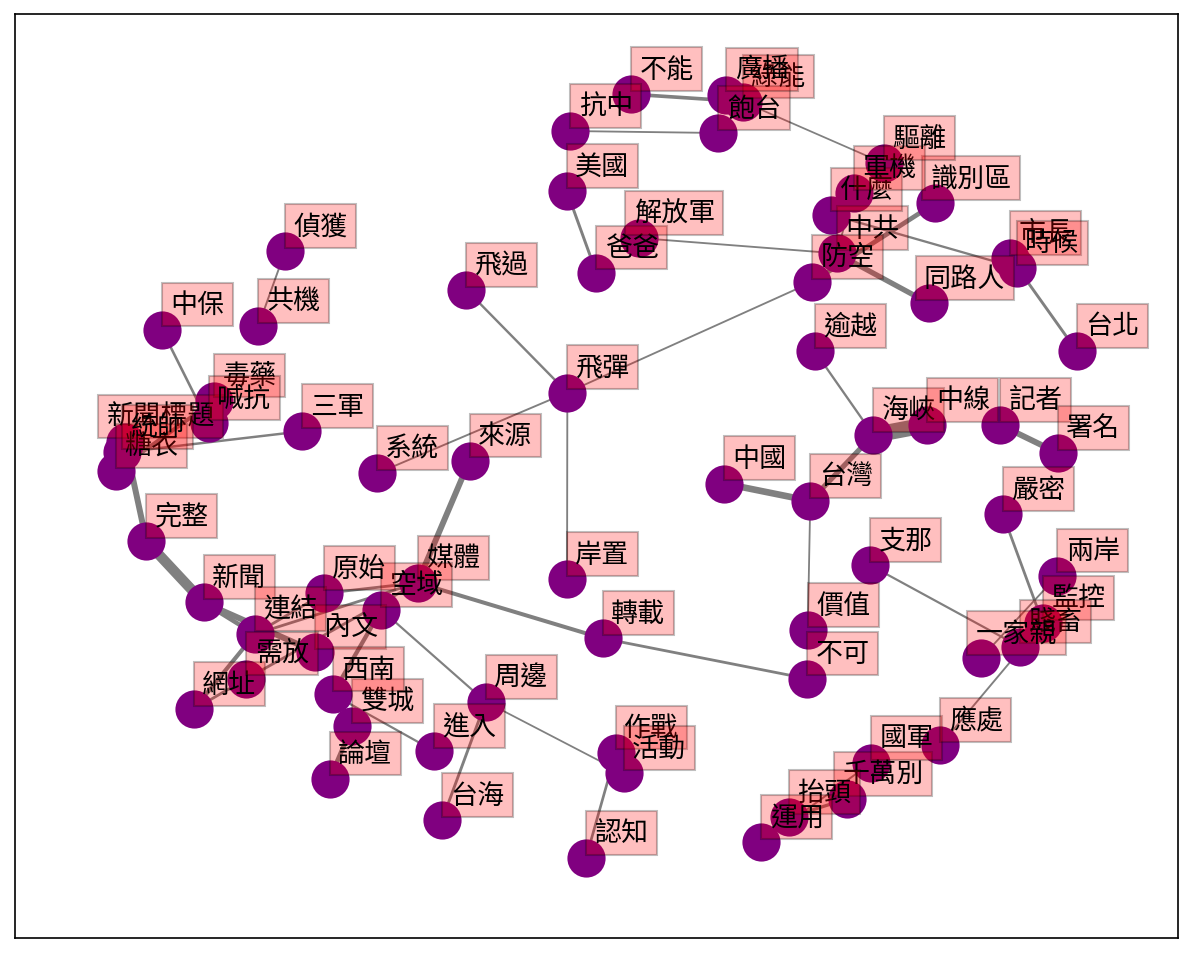

In [115]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center',fontproperties=fprop, fontsize=13,)


plt.show()

In [116]:
# 使用FreqDist 取得 trigram 斷詞 與 triigram出現頻率
trigramfdist = FreqDist()
def trigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if len(w)>1]
    trigramfdist.update(ngrams(seg_list, 3))
    seg_list2 = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [117]:
trigram = sent_df.copy()
trigram["word"] = trigram.sentence.apply(trigram_getToken_dict)

In [118]:
trigram = trigram.explode('word')# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in trigramfdist.most_common(50)}
d

{('完整', '新聞', '內文'): 285,
 ('完整', '新聞', '連結'): 209,
 ('新聞', '連結', '網址'): 198,
 ('網址', '需放', '媒體'): 134,
 ('需放', '媒體', '原始'): 134,
 ('媒體', '原始', '連結'): 134,
 ('不可', '轉載', '媒體'): 134,
 ('轉載', '媒體', '連結'): 134,
 ('逾越', '海峽', '中線'): 110,
 ('進入', '西南', '空域'): 93,
 ('連結', '網址', '需放'): 93,
 ('嚴密', '監控', '應處'): 87,
 ('系統', '嚴密', '監控'): 83,
 ('岸置', '飛彈', '系統'): 82,
 ('運用', '任務', '艦及'): 81,
 ('任務', '艦及', '岸置'): 81,
 ('艦及', '岸置', '飛彈'): 81,
 ('飛彈', '系統', '嚴密'): 80,
 ('國軍', '運用', '任務'): 79,
 ('台灣', '海峽', '中線'): 70,
 ('架次', '共艦', '艘次'): 67,
 ('違者', '新聞', '文章'): 62,
 ('新聞', '文章', '刪除'): 62,
 ('備註', '請放', '最後'): 61,
 ('請放', '最後', '違者'): 61,
 ('最後', '違者', '新聞'): 61,
 ('海峽', '中線', '及其'): 61,
 ('中線', '及其', '延伸線'): 61,
 ('時空', '背景', '不同'): 60,
 ('from', 'JPTT', 'on'): 59,
 ('JPTT', 'on', 'my'): 59,
 ('及其', '延伸線', '進入'): 59,
 ('延伸線', '進入', '西南'): 59,
 ('網址', '不可', 'YAHOO'): 58,
 ('不可', 'YAHOO', 'LINE'): 58,
 ('YAHOO', 'LINE', 'MSN'): 58,
 ('LINE', 'MSN', '轉載'): 58,
 ('MSN', '轉載', '媒體'): 58,
 ('台海', '周邊', 

觀察bigram及trigram之結果，將以下詞加入自訂義辭典：
海峽中線、推、中共 中國、柯文哲、蔡英文、何博文、中共同路人、防空識別區、西南空域、台灣海峽、千萬別抬頭、三軍統帥、不可轉載、抗中保台、糖衣毒藥、雙城論壇

In [119]:
# 設定繁體中文詞庫
jieba.set_dictionary('./MIDTERM/week8/dict/dict.txt.big')
jieba.load_userdict("./MIDTERM/week4_nlp/dict/user_dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./MIDTERM/week4_nlp/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\Users\USER\Desktop\社群媒體與分析 - 複製\MIDTERM\week8\dict\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.ub9c3e096d7fe4924bf48bbe41af87437.cache
Loading model cost 1.952 seconds.
Prefix dict has been built successfully.


In [120]:
#斷詞
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [
    line.strip()
    for line in open("./MIDTERM/week4_nlp/dict/stopwords.txt", "r", encoding="utf-8").readlines()
]
#刪除停用詞
noStop_df = word_df[~word_df["word"].isin(stopwords)]
noStop_df

,system_id,artDate,word
0,0,2021-01-04,小島
0,0,2021-01-04,戰略
0,0,2021-01-04,縱深
1,0,2021-01-04,石油
1,0,2021-01-04,天然氣
...,...,...,...
128580,73670,2023-04-14,選擇
128580,73670,2023-04-14,戰爭
128581,73670,2023-04-14,死掉
128581,73670,2023-04-14,接受


### 3.2 詞頻分析

In [121]:
#計算詞頻
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,台灣,6170
1,中國,3821
2,中共,2355
3,美國,2246
4,民進黨,2243
...,...,...
47173,極權國家,1
47174,極權主義,1
47175,區則,1
47176,極樂,1


#### 分析結果：詞頻前10高長條圖
透過長條圖可以發現，話題多圍繞在事件之相關國家、執政黨等，而「笑死」之詞頻高，可視為鄉民之嘲諷意味可能偏高

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

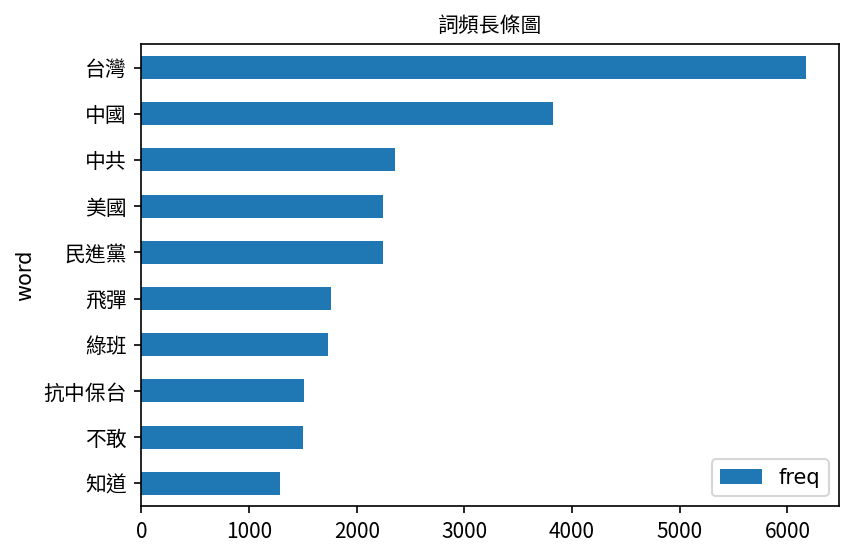

In [122]:
#ptt
freq_df.iloc[:10].plot.barh(x='word', y='freq').invert_yaxis()
plt.title("詞頻長條圖", 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.show()

#### 分析結果：討論熱度趨勢圖
從圖中可以發現幾個時間段討論度特別高，經進一步查詢後發現：
1. 2021/10 ~2021/12（第一波高峰）：可能原因為10月適逢中國國慶，故有些武力展示的動作等。
2. 2022/7 ~ 2022/10（第二波高峰）：可能與美國眾議院議長裴洛西8月初訪台有關。

而從整體趨勢來看，台灣鄉民對此事件之討論度，除非有事件伴隨發生，不然其實討論度沒有特別高


In [123]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

# ptt_df["artDate"].describe(datetime_is_numeric=True)
ptt_df["artDate"] = ptt_df["artDate"].dt.date

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

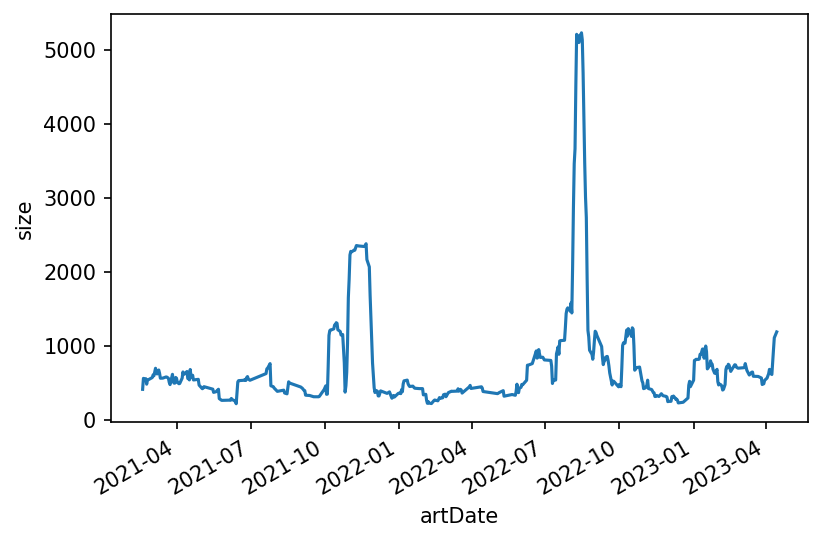

In [124]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()
fig, ax = plt.subplots()
rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())

ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

### 3.3 情緒分析

從整體折線圖中可以看出，鄉民對於共機擾台的情緒大多時間維持負面，我們推測有少數正面情緒大於負面情緒的可能性如下：
1. 2021/10~2022/1:推測因為10月中國發布2022ECFA(兩岸經貿協議)之新的降稅措施而讓鄉民之負面情緒字眼降低，導致最終正面情緒大於負面情緒
2. 2022/10~2022/12:推測因為適逢選前，版上可能參雜一些選舉相關宣傳文字，造成其時間段之正面情緒高於負面情緒

In [125]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./Midterm/week4_nlp/dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [126]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,word,sentiments
0,2021-01-04,小島,NaN
1,2021-01-04,戰略,NaN
2,2021-01-04,縱深,NaN
3,2021-01-04,石油,NaN
4,2021-01-04,天然氣,NaN
...,...,...,...
391541,2023-04-14,戰爭,negative
391542,2023-04-14,戰爭,anger
391543,2023-04-14,死掉,NaN
391544,2023-04-14,接受,NaN


In [127]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2021-01-04,affect,15
1,2021-01-04,anger,5
2,2021-01-04,negative,6
3,2021-01-04,positive,9
4,2021-01-04,NaN,167
...,...,...,...
2412,2023-04-14,anger,25
2413,2023-04-14,anx,3
2414,2023-04-14,negative,36
2415,2023-04-14,positive,42


In [128]:
#每天之各個情緒類別總數
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2021-01-04,affect,15,0.074257
1,2021-01-04,anger,5,0.024752
2,2021-01-04,negative,6,0.029703
3,2021-01-04,positive,9,0.044554
4,2021-01-04,NaN,167,0.826733
...,...,...,...,...
2412,2023-04-14,anger,25,0.026567
2413,2023-04-14,anx,3,0.003188
2414,2023-04-14,negative,36,0.038257
2415,2023-04-14,positive,42,0.044633


In [129]:
#計算正負面情緒總數
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

#### 分析結果：正負面情緒比例折線圖
從整體折線圖中可以看出，鄉民對於共機擾台的情緒大多時間維持負面，我們推測有少數正面情緒大於負面情緒的可能性如下：
1. 2021/10~2022/1:推測因為10月中國發布2022ECFA(兩岸經貿協議)之新的降稅措施而讓鄉民之負面情緒字眼降低，導致最終正面情緒大於負面情緒
2. 2022/10~2022/12:推測因為適逢選前，版上可能參雜一些選舉相關宣傳文字，造成其時間段之正面情緒高於負面情緒

Text(0.5, 1.0, '正負情緒比例折線圖')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

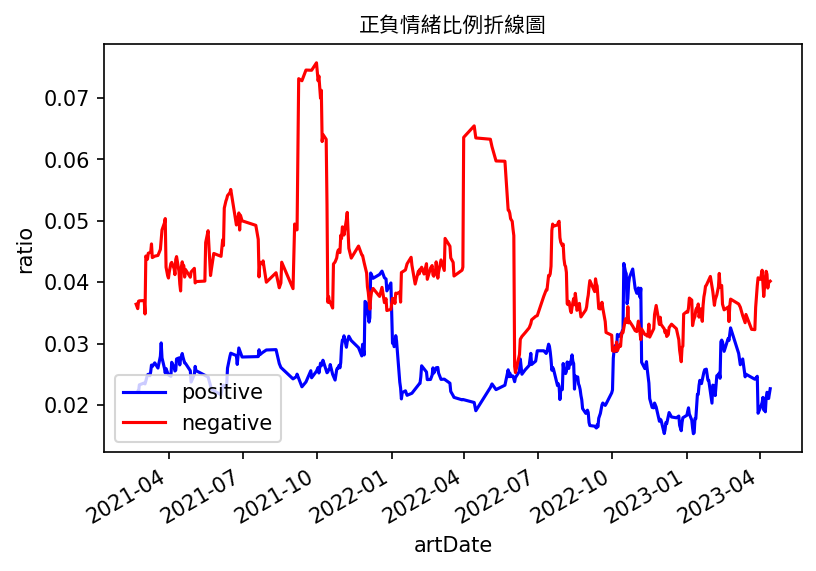

In [130]:
fig, ax = plt.subplots()
colors = ['blue','red',]
rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

#### 分析結果：正面情緒文字雲

In [155]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head(10)

,artDate,sentiments,size,ratio
1454,2022-08-06,positive,330,0.034425
749,2021-10-30,positive,307,0.030490
1468,2022-08-08,positive,296,0.022345
1447,2022-08-05,positive,292,0.021842
1475,2022-08-09,positive,269,0.024738
1343,2022-07-15,positive,229,0.024037
1433,2022-08-03,positive,205,0.028179
756,2021-10-31,positive,204,0.042280
1440,2022-08-04,positive,183,0.017852
2387,2023-04-09,positive,169,0.042548


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\3540481063.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


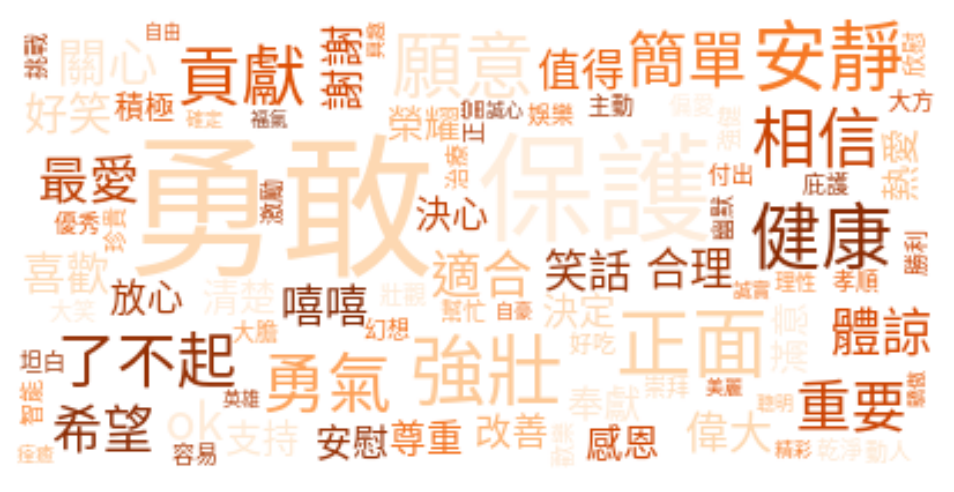

In [156]:
date = "2021-10-30"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./Midterm/week3_nlp/raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
plt.show()

#### 分析結果：負面情緒文字雲

In [133]:
mask = sentiment_count['sentiments'] == 'negative'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
1467,2022-08-08,negative,579,0.043708
1446,2022-08-05,negative,551,0.041215
748,2021-10-30,negative,550,0.054623
1342,2022-07-15,negative,439,0.046080
1453,2022-08-06,negative,434,0.045274


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\2653321351.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] >= pd.Timestamp(startdate)) &(ptt_liwc_df["artDate"] <= pd.Timestamp(enddate))


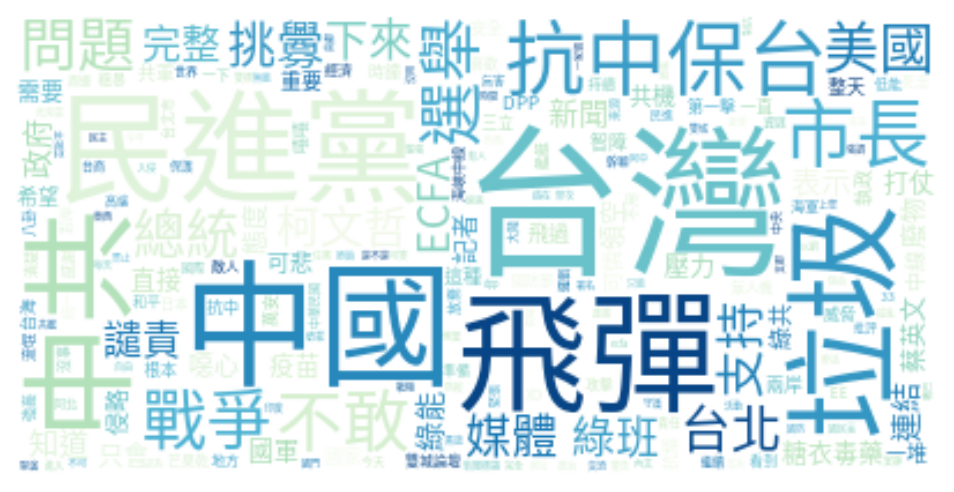

In [164]:
date = "2022-08-08"
startdate = "2022-10-01"
enddate = "2022-11-30"
mask = (ptt_liwc_df["artDate"] >= pd.Timestamp(startdate)) &(ptt_liwc_df["artDate"] <= pd.Timestamp(enddate))

ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./Midterm/week3_nlp/raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
plt.show()

#### 分析結果：每日情緒分數趨勢
依討論熱度之趨勢圖可知，兩個低點分別為1.適逢中國國慶 2.美國眾議院議長裴洛西8月初訪台，導致共機頻繁擾台，因而鄉民們之負面情緒有顯著增加。

In [135]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2021-01-04,15,5,0,6,9,0
1,2021-01-13,9,2,3,5,4,0
2,2021-01-16,83,22,2,51,27,16
3,2021-01-23,15,4,0,7,7,1
4,2021-01-24,2,1,0,2,0,0


In [136]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2021-01-04,15,5,0,6,9,0,-2
1,2021-01-13,9,2,3,5,4,0,-6
2,2021-01-16,83,22,2,51,27,16,-64
3,2021-01-23,15,4,0,7,7,1,-5
4,2021-01-24,2,1,0,2,0,0,-3


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

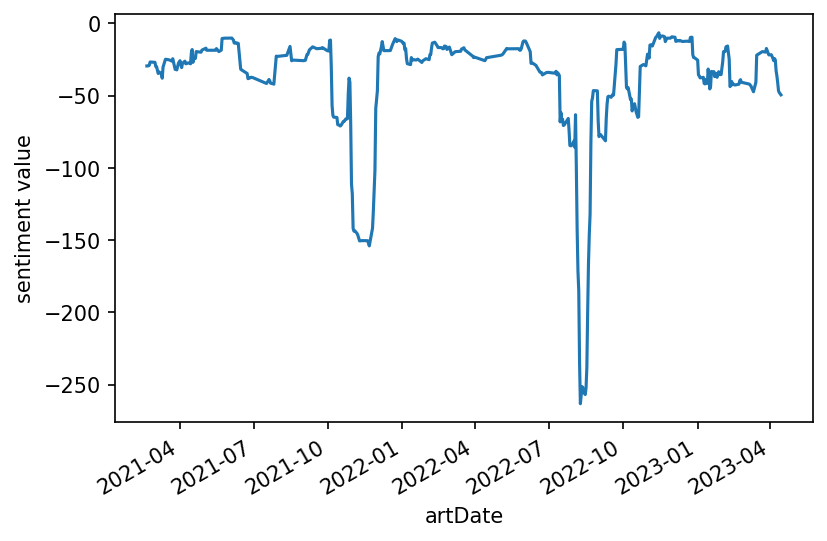

In [137]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

### 3.4 詞性標注(POS)、實體型態識別(NER)

In [59]:
#引入套件
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Python311\Lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Python311\Lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Python311\Lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [60]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [61]:
word_to_weight = {
    "海峽中線":500,
    "柯文哲":500,
    "蔡英文":500,
    "塔綠班":500,
    "抗中保台":500
}
dictionary2 = construct_dictionary(word_to_weight)
print(dictionary2)

[(3, {'柯文哲': 500.0, '蔡英文': 500.0, '塔綠班': 500.0}), (4, {'海峽中線': 500.0, '抗中保台': 500.0})]


In [62]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

#### 3.4.1 POS標註

In [63]:
pos_table, entity_table, sentence_table = get_nlp_result(final)

time costing: 5837.757784128189


#### 3.4.2 NER 種類分析

In [64]:
entity_table['ner'].unique()

array(['PERCENT', 'NORP', 'GPE', 'PERSON', 'CARDINAL', 'DATE', 'LOC',
       'ORG', 'TIME', 'ORDINAL', 'QUANTITY', 'WORK_OF_ART', 'PRODUCT',
       'FAC', 'EVENT', 'LANGUAGE', 'LAW', 'MONEY'], dtype=object)

In [65]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
4,GPE,21430
11,ORG,14829
13,PERSON,12985
1,DATE,3539
7,LOC,3086
0,CARDINAL,2669
9,NORP,2494
3,FAC,766


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\3664628769.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif'

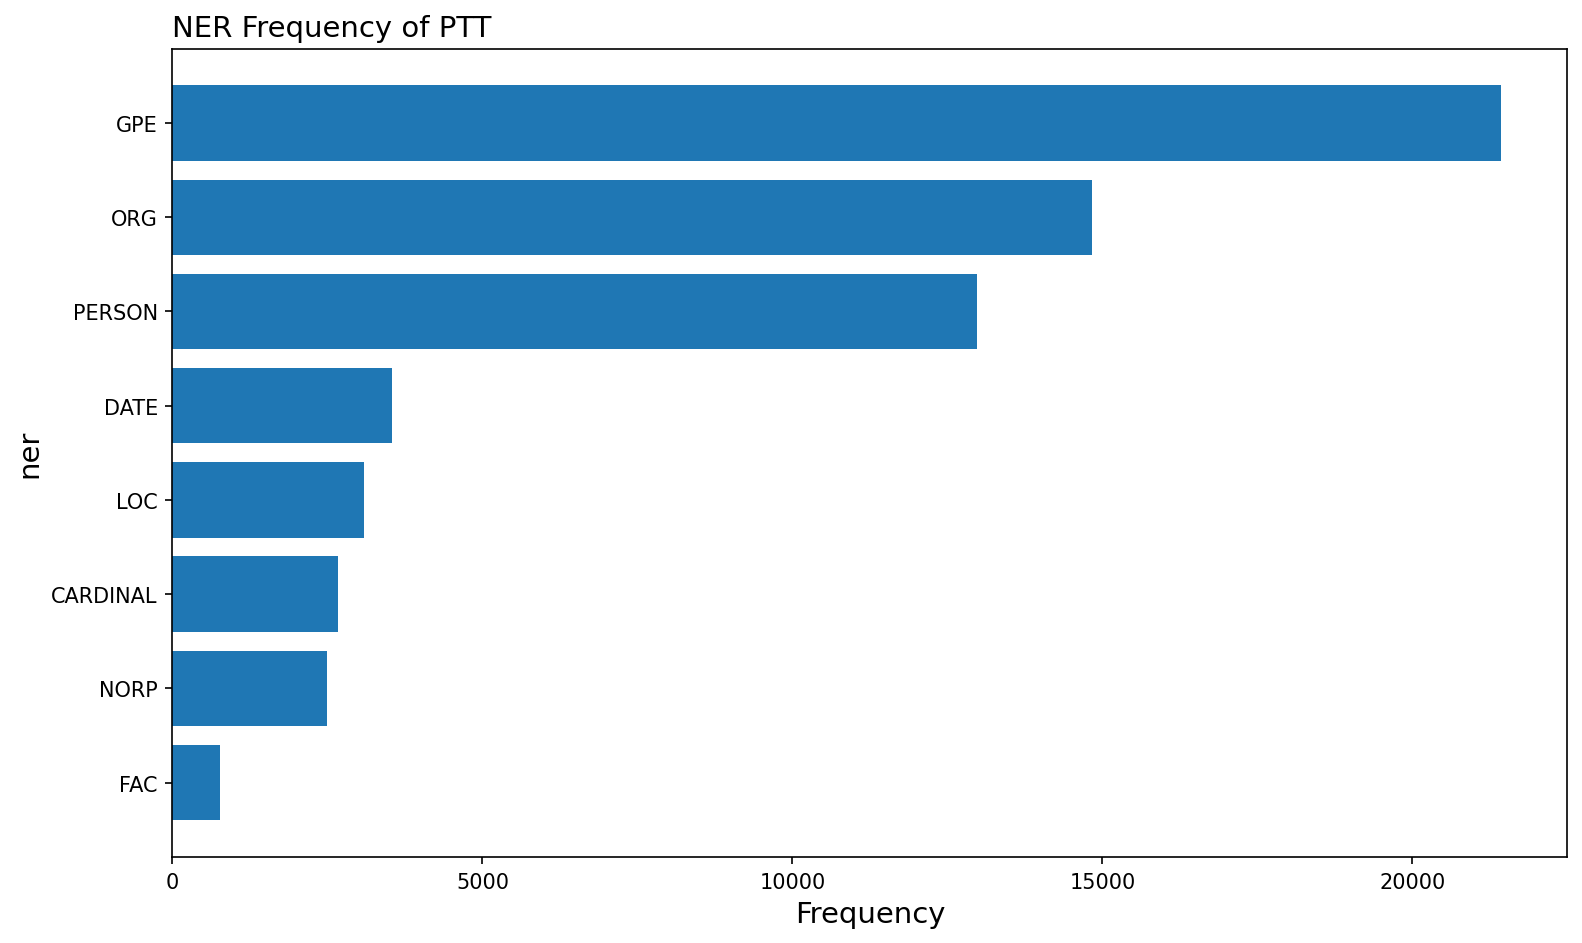

In [66]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### 分析結果：涉及到的人名(PERSON)

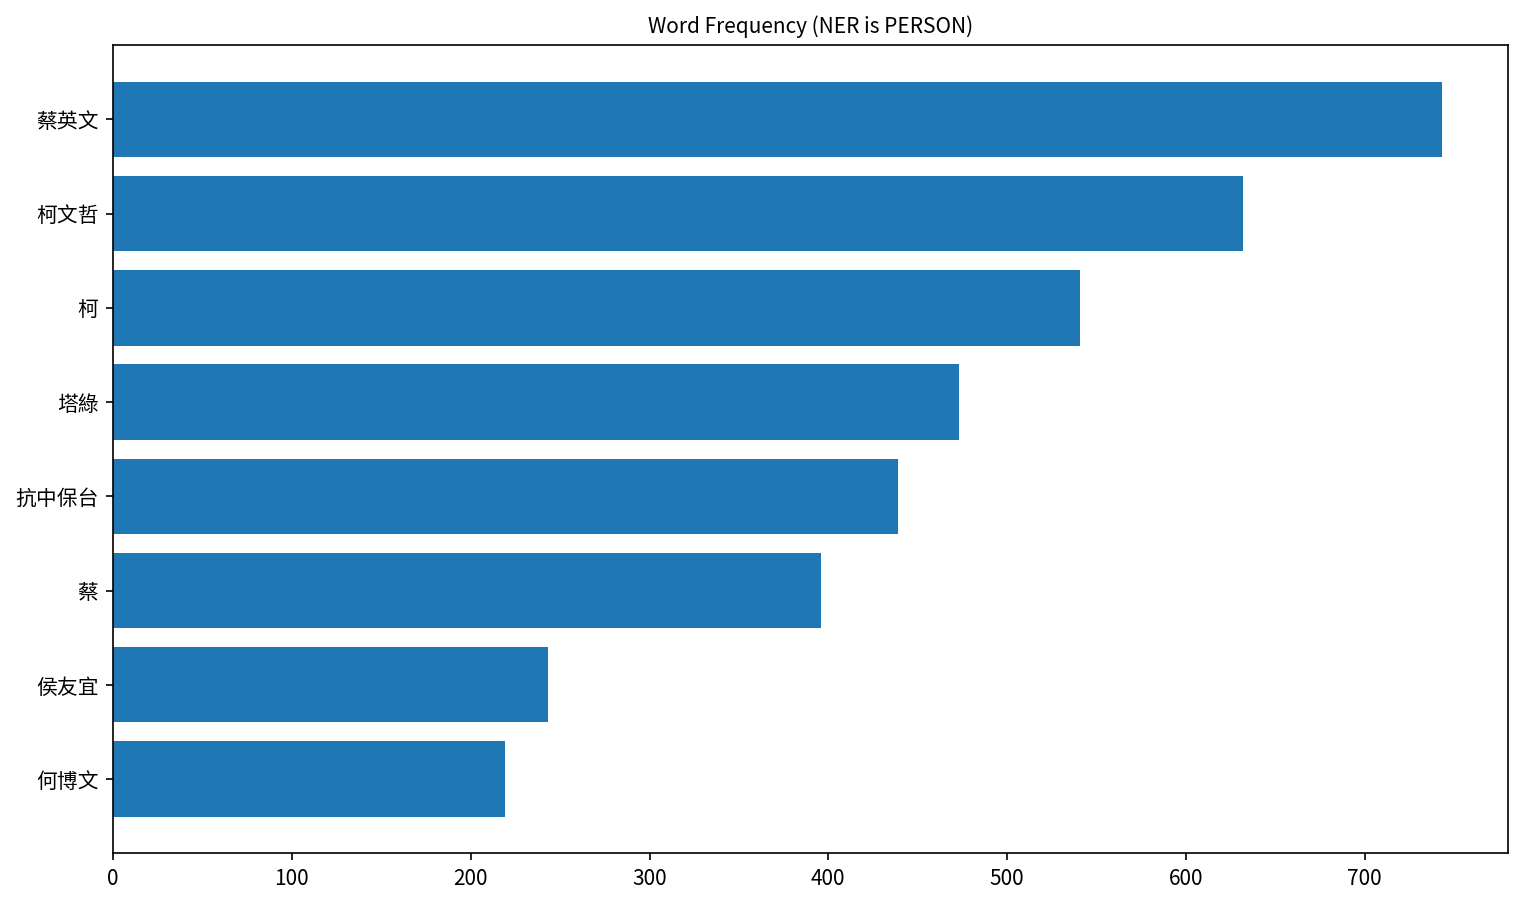

In [67]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']
fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
plt.title("Word Frequency (NER is PERSON)", 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.show()

#### 分析結果：涉及到的組織(ORG)

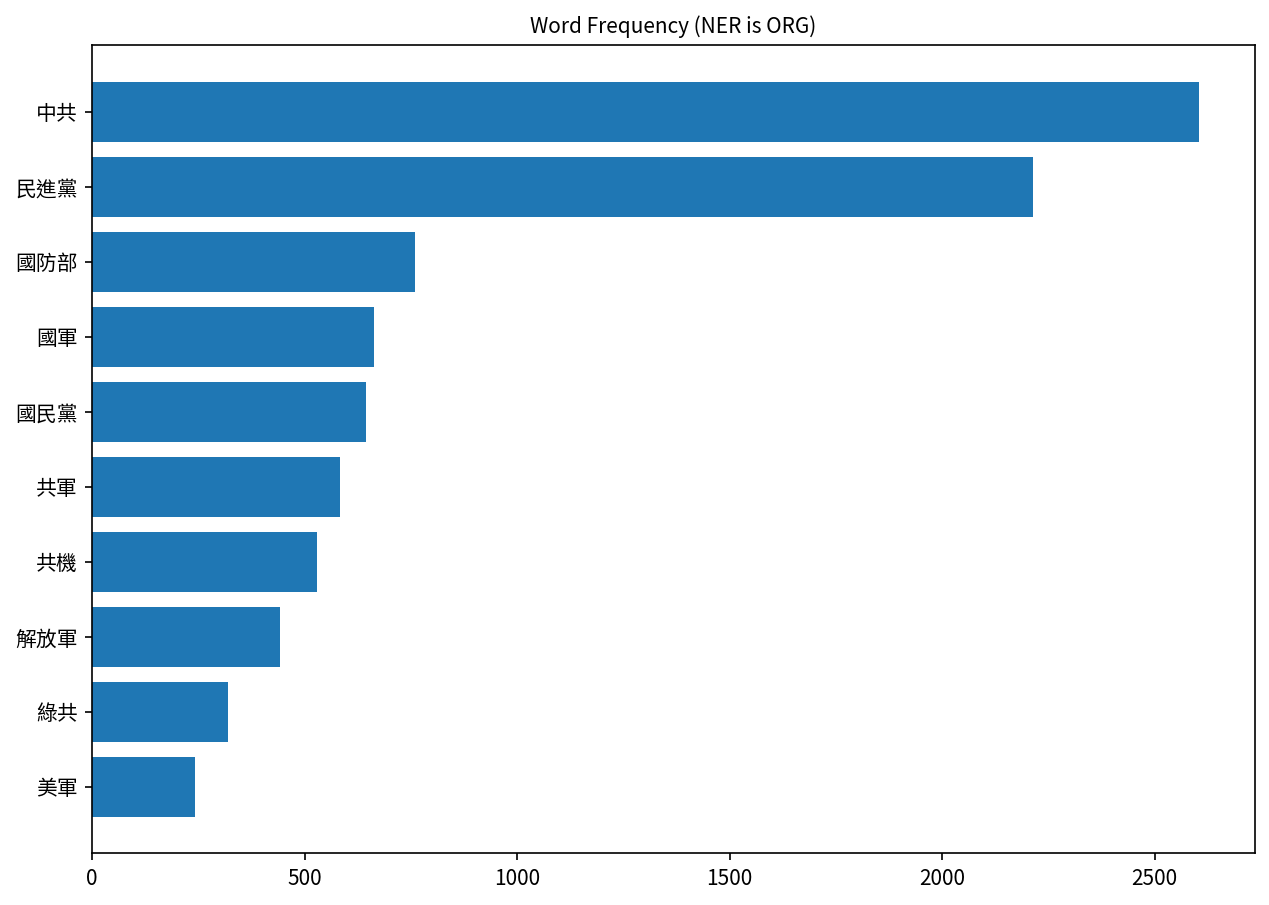

In [68]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()

plt.title('Word Frequency (NER is ORG)', 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.show()

#### 3.4.3 POS 種類分析

In [69]:
pos_table['pos'].unique()

array(['D', 'Nf', 'Na', 'T', 'VJ', 'VH', 'Neqa', 'VC', 'Ncd', 'P', 'Nc',
       'SHI', 'Di', 'COMMACATEGORY', 'Nep', 'VE', 'Ng', 'Nes', 'DE', 'A',
       'V_2', 'Cbb', 'VA', 'VCL', 'VB', 'Nb', 'VHC', 'FW', 'Nd', 'Nh',
       'VF', 'Neu', 'VG', 'Nv', 'VK', 'Dfa', 'VD', 'Caa', 'VI', 'VL',
       'Da', 'Cab', 'I', 'VAC', 'PERIODCATEGORY', 'PARENTHESISCATEGORY',
       'Dk', 'COLONCATEGORY', 'Cba', 'DM', 'Neqb', 'Dfb', 'DASHCATEGORY'],
      dtype=object)

In [70]:
#看看除了標點符號，大部分的POS都是哪一類
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
16,Na,134402
5,D,103450
36,VC,61740
42,VH,46903
18,Nc,46429
33,VA,26858
30,P,25963
32,T,23706
28,Nh,22383
17,Nb,22296


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif'

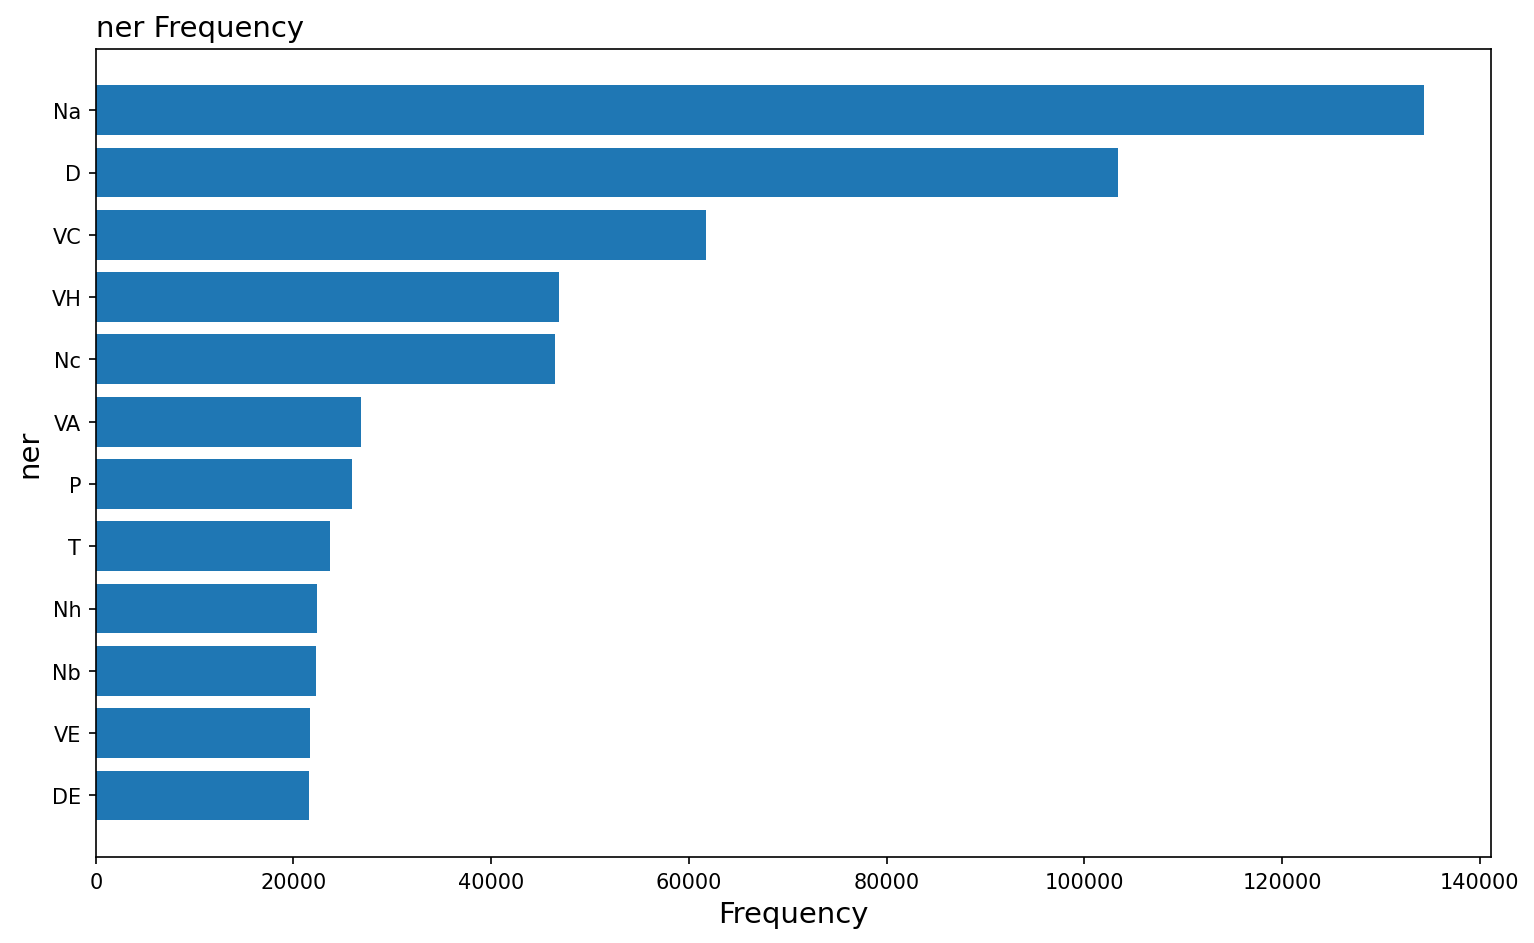

In [71]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### 分析結果：涉及到的名詞(Noun)


In [72]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
41,中共,2723
1871,民進黨,2246
2796,蔡英文,747
677,國民黨,668
1669,柯文哲,640
1619,柯,548
2340,綠共,418
2719,蔡,410
3350,阿共,247
187,侯友宜,240


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\1240904845.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif'

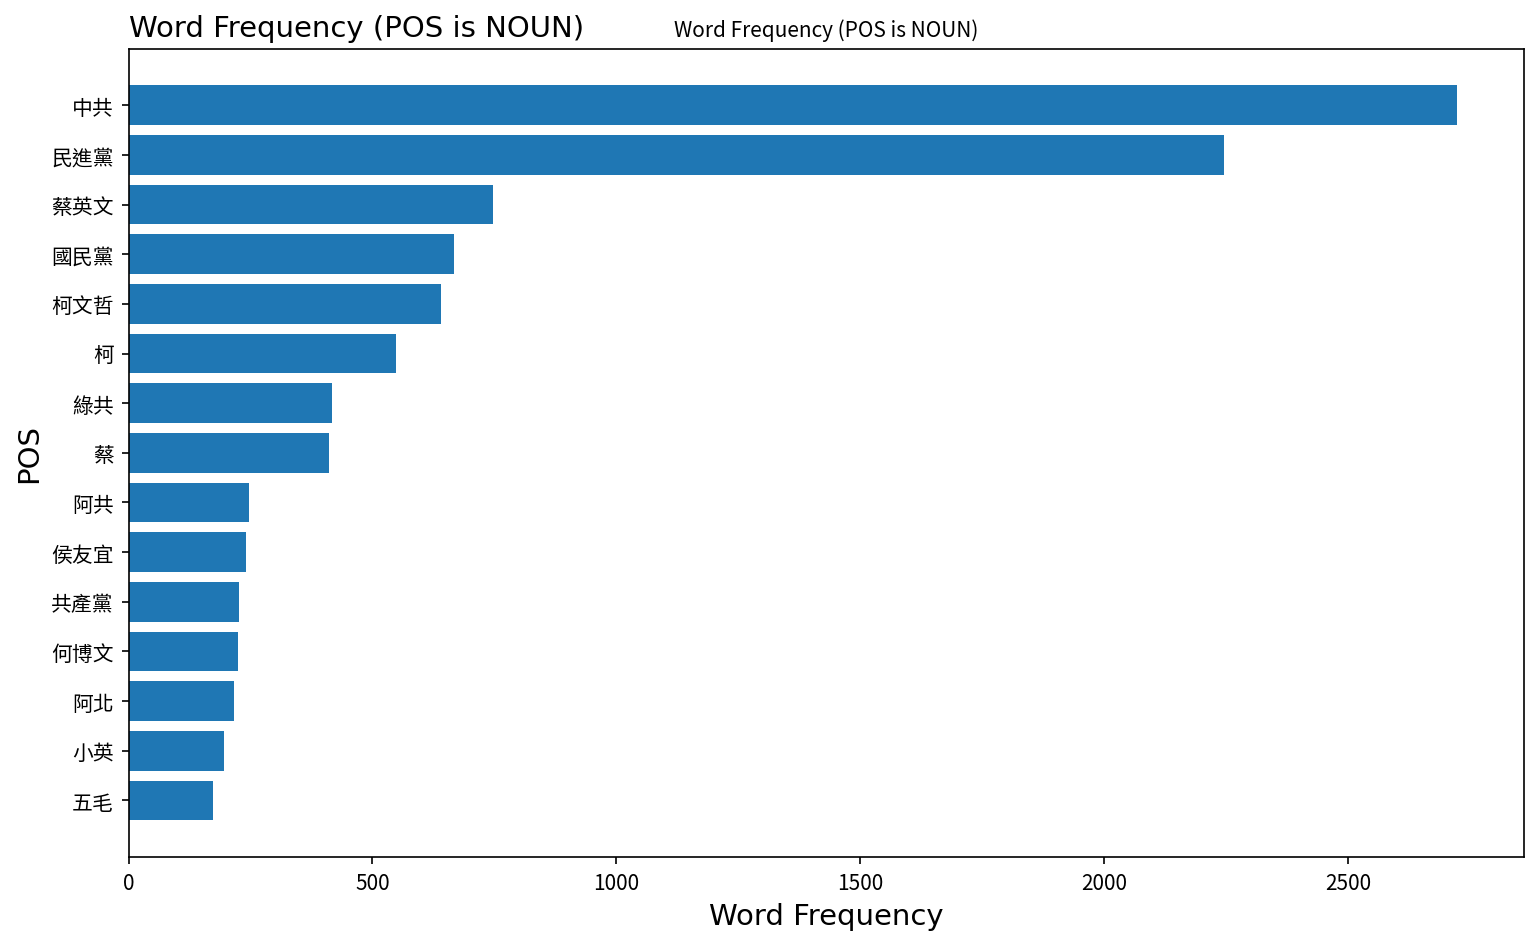

In [73]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

plt.title('Word Frequency (POS is NOUN)',
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.show()

#### 分析結果：涉及到的動詞(VERB)

In [74]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
2607,支持,577
4753,連結,574
4428,譴責,442
4770,進行,335
3898,署名,287
3481,監控,266
2187,接受,258
5109,面對,228
5197,驅離,228
203,保護,226


C:\Users\USER\AppData\Local\Temp\ipykernel_21116\2768623442.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif'

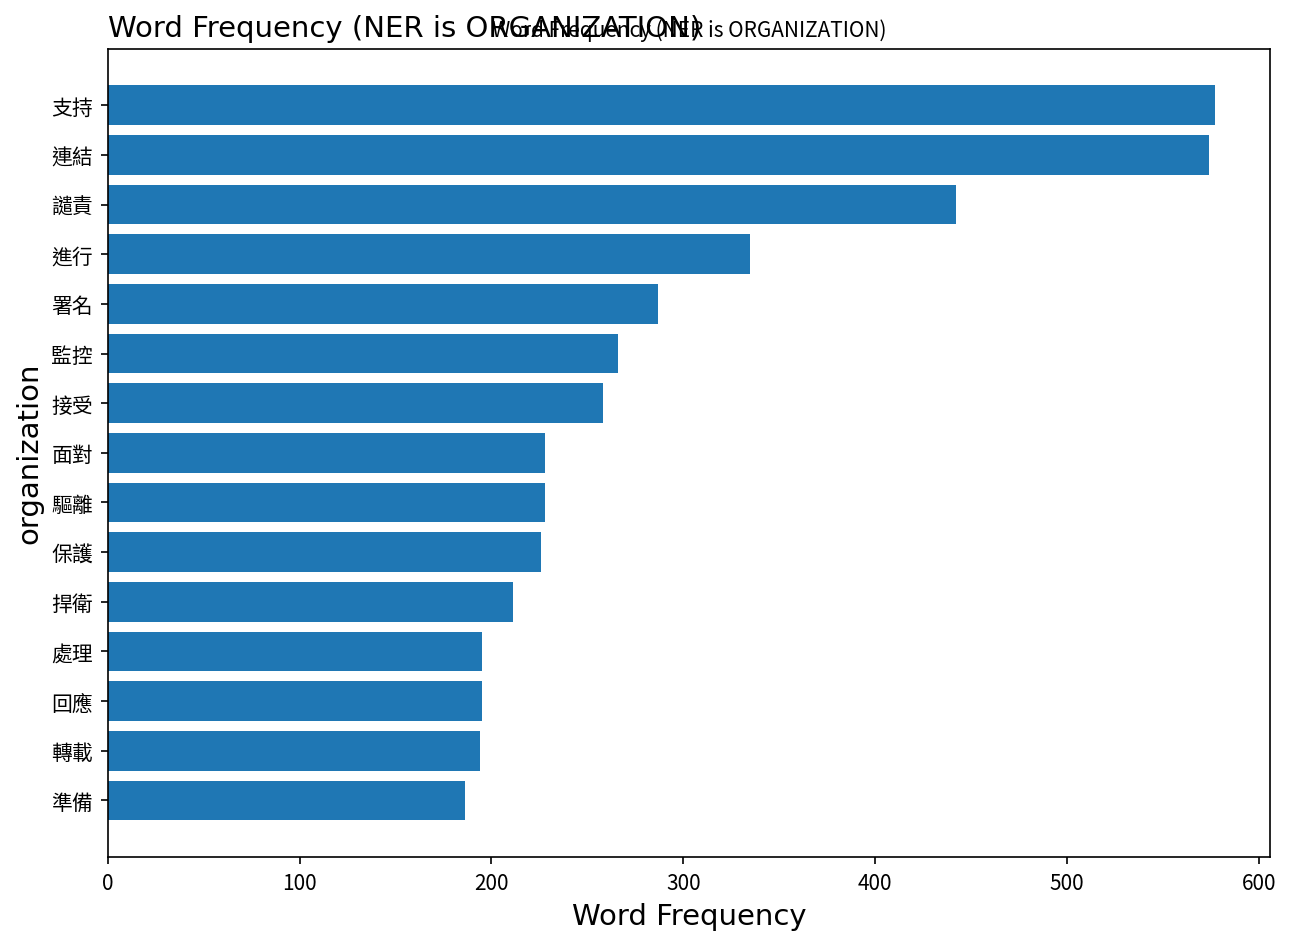

In [75]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

plt.title('Word Frequency (NER is ORGANIZATION)', 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.xticks(fontproperties=fprop)
plt.yticks(fontproperties=fprop)
plt.show()

### 3.5 文詞相似度分析

#### 3.5.1 資料前處理

In [108]:
MetaData = final_article.copy()

In [110]:
# 移除網址格式
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
# 只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,mcuronan,Gossiping,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""marktak"", ""c...",49.216.138.249,2021-01-05 00:23:38,ptt,就一個小島而已沒有戰略縱深石油天然氣煤炭能源百分百進口糧食自給率以上要靠對岸台灣人不是白人美...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1610550608....,[問卦]有沒有中國航母的八卦,2021-01-13 23:10:06,CenaC,Gossiping,今天我公司有個在中國的PE\n\n密我跟我說中國正準備在做第4艘航母\n\n等到航母數量夠多...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""gigongwen"", ...",36.225.185.45,2021-01-14 00:56:21,ptt,今天我公司有個在中國的密我跟我說中國正準備在做第艘航母等到航母數量夠多也許在左右會有事情發生...
2,3,https://www.ptt.cc/bbs/Gossiping/M.1610774066....,[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,2021-01-16 13:14:23,fantazy00077,Gossiping,共機擾台罕見激烈對話交鋒 不明聲源嗆「閉上你的臭嘴巴！」\n\n自由時報 2021/01/1...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Grandslammmm...",111.71.64.248,2021-01-17 00:49:41,ptt,共機擾台罕見激烈對話交鋒不明聲源嗆閉上你的臭嘴巴自由時報記者蔡宗憲屏東報導解放軍軍機密集襲擾...


In [111]:
# 設定繁體中文詞庫
jieba.set_dictionary('./MIDTERM/week8/dict/dict.txt.big')
jieba.load_userdict("./MIDTERM/week4_nlp/dict/user_dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./MIDTERM/week4_nlp/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /Users/cloudo/Desktop/大學/社群媒體分析/project/MIDTERM/week8/dict/dict.txt.big ...
Loading model from cache /var/folders/6s/ywg_j_n577l087btck6yqqw00000gn/T/jieba.ucefa085b4c5aa9a6bf9045c2b2526c41.cache
Loading model cost 0.530 seconds.
Prefix dict has been built successfully.


In [112]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [113]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,mcuronan,Gossiping,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""marktak"", ""c...",49.216.138.249,2021-01-05 00:23:38,ptt,就一個小島而已沒有戰略縱深石油天然氣煤炭能源百分百進口糧食自給率以上要靠對岸台灣人不是白人美...,小島
0,1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,mcuronan,Gossiping,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""marktak"", ""c...",49.216.138.249,2021-01-05 00:23:38,ptt,就一個小島而已沒有戰略縱深石油天然氣煤炭能源百分百進口糧食自給率以上要靠對岸台灣人不是白人美...,戰略
0,1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,mcuronan,Gossiping,就一個小島而已沒有戰略縱深\n\n石油天然氣煤炭能源百分百進口\n\n糧食自給率 ?\n\n...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""marktak"", ""c...",49.216.138.249,2021-01-05 00:23:38,ptt,就一個小島而已沒有戰略縱深石油天然氣煤炭能源百分百進口糧食自給率以上要靠對岸台灣人不是白人美...,縱深


#### 3.5.2 TF-IDF

In [114]:
# 計算每篇文章的 總詞彙數 與 各個詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,170
1,https://www.ptt.cc/bbs/Gossiping/M.1610550608....,172
2,https://www.ptt.cc/bbs/Gossiping/M.1610774066....,122
3,https://www.ptt.cc/bbs/Gossiping/M.1610779845....,47
4,https://www.ptt.cc/bbs/Gossiping/M.1610790964....,42
...,...,...
811,https://www.ptt.cc/bbs/Gossiping/M.1681230703....,88
812,https://www.ptt.cc/bbs/Gossiping/M.1681275985....,87
813,https://www.ptt.cc/bbs/Gossiping/M.1681298990....,292
814,https://www.ptt.cc/bbs/Gossiping/M.1681429477....,695


In [115]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一個打,1
1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一再,1
2,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一堆,3
3,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一打,1
4,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一群,1
...,...,...,...
210118,https://www.ptt.cc/bbs/Gossiping/M.1681431560....,領土,2
210119,https://www.ptt.cc/bbs/Gossiping/M.1681431560....,飛彈,6
210120,https://www.ptt.cc/bbs/Gossiping/M.1681431560....,飛越,2
210121,https://www.ptt.cc/bbs/Gossiping/M.1681431560....,飛過,1


In [116]:
food_words = word_count.merge(total_words,on = 'artUrl',how = 'left')

In [117]:
# 計算 tf-idf 值 - tf值
food_words_tf_idf = food_words.assign(tf = food_words.iloc[:,2]/food_words.iloc[:,3])
food_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一個打,1,170,0.005882
1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一再,1,170,0.005882
2,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一堆,3,170,0.017647
3,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一打,1,170,0.005882
4,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一群,1,170,0.005882


In [118]:
# 計算每個詞彙出現在幾篇文章中
idf_df = food_words.groupby(['word'],as_index=False).size()
food_words_tf_idf = food_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
food_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一個打,1,170,0.005882,3
1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一再,1,170,0.005882,24
2,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一堆,3,170,0.017647,253
3,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一打,1,170,0.005882,25
4,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一群,1,170,0.005882,60


In [119]:
# 計算 tf-idf 值 - idf值
food_words_tf_idf = food_words_tf_idf.assign(idf = food_words_tf_idf.iloc[:,5]# 將每一個size作為x來運算
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

food_words_tf_idf = food_words_tf_idf.drop(labels=['size'],axis=1)
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一個打,1,170,0.005882,2.434569
1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一再,1,170,0.005882,1.531479
2,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一堆,3,170,0.017647,0.508570
3,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一打,1,170,0.005882,1.513750
4,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一群,1,170,0.005882,1.133539


In [120]:
# 計算tf*idf
food_words_tf_idf = food_words_tf_idf.assign(tf_idf = food_words_tf_idf.iloc[:,4] * food_words_tf_idf.iloc[:,5])
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一個打,1,170,0.005882,2.434569,0.014321
1,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一再,1,170,0.005882,1.531479,0.009009
2,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一堆,3,170,0.017647,0.508570,0.008975
3,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一打,1,170,0.005882,1.513750,0.008904
4,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,一群,1,170,0.005882,1.133539,0.006668


#### 分析結果：tf-idf
從結果中可以發現，架次為資料集之文章中最重要的詞，可能的原因為ptt文章有多數文新聞轉載，而新聞通常會提及每次共軍擾台的軍機架次。而另有提到柯文哲及雙城論壇，故大家的討論重點可能從共軍擾台的議題，延伸討論到每年年底之台北上海經貿論壇。

In [121]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [122]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/Gossiping/M.1609734453.A... 136   除役  0.022490
                                                   89    澳洲  0.019487
                                                   34    取代  0.019211
                                                   5    三十個  0.017128
                                                   6     三星  0.017128
https://www.ptt.cc/bbs/Gossiping/M.1610550608.A... 244   航母  0.061290
                                                   162   剩菜  0.033857
                                                   194   打贏  0.028093
                                                   164   動手  0.027034
                                                   155   他問  0.025729
https://www.ptt.cc/bbs/Gossiping/M.1610774066.A... 339   閉上  0.064197
                                                   296   廣播  0.050420
                                                   342   驅離  0.045933
                                                   267   不明  0.043415
                                                   332   記錄  0.043415

In [123]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(food_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
3390,架次,32
3406,柯文哲,31
324,中線,28
161,下來,26
575,何博文,20
5698,雙城論壇,19
3922,無人機,18
4121,當兵,17
631,侯友宜,15
5259,軍聞社,15


### 3.6 計算文章相似度

In [124]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)
data_cos.head(3)

,artTitle,artDate,artUrl,sentence,word
0,[問卦]台灣有戰爭的條件嗎？,2021-01-04 12:27:31,https://www.ptt.cc/bbs/Gossiping/M.1609734453....,就一個小島而已沒有戰略縱深石油天然氣煤炭能源百分百進口糧食自給率以上要靠對岸台灣人不是白人美...,小島 戰略 縱深 石油 天然氣 煤炭 能源 百分百 進口 糧食 自給率 對岸 台灣 白人 美...
1,[問卦]有沒有中國航母的八卦,2021-01-13 23:10:06,https://www.ptt.cc/bbs/Gossiping/M.1610550608....,今天我公司有個在中國的密我跟我說中國正準備在做第艘航母等到航母數量夠多也許在左右會有事情發生...,今天 公司 有個 中國 中國 準備 第艘 航母 航母 數量 夠多 也許 左右 事情 發生 中...
2,[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,2021-01-16 13:14:23,https://www.ptt.cc/bbs/Gossiping/M.1610774066....,共機擾台罕見激烈對話交鋒不明聲源嗆閉上你的臭嘴巴自由時報記者蔡宗憲屏東報導解放軍軍機密集襲擾...,共機擾 罕見 激烈 對話 交鋒 不明 聲源 閉上 嘴巴 自由 時報 記者 蔡宗憲 屏東 報導...


In [125]:
# Bag of Word
# 篩選至少出現在5篇文章以上的詞彙
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names_out()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一下,一中,一事,一事無成,一人,一代,一件,一任,一份,...,黨證,黨還,黨部,鼓動,鼓勵,鼓吹,鼻孔,龐大,龜兒子,龜縮
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
813,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
814,0,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一一,一下,一中,一事,一事無成,一人,一代,一件,一任,一份,...,黨證,黨還,黨部,鼓動,鼓勵,鼓吹,鼻孔,龐大,龜兒子,龜縮
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.076692,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
812,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
813,0.0,0.000000,0.000000,0.049797,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
814,0.0,0.049582,0.024686,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [127]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

In [128]:
print(tfidf.toarray()[2])
cos_df = cosine_similarity(tfidf.toarray()[2])

[0. 0. 0. ... 0. 0. 0.]


#### 分析結果：文章相似度


In [129]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
2,1.000000,[新聞]共機擾台罕見激烈對話交鋒不明聲源嗆「,https://www.ptt.cc/bbs/Gossiping/M.1610774066....
66,0.590723,[新聞]「哩靠杯喔！」共機囂張擾台不明音源回,https://www.ptt.cc/bbs/Gossiping/M.1618941064....
124,0.419104,[新聞]不滿遭我軍驅離共機謎之音飆罵「X你個媽,https://www.ptt.cc/bbs/Gossiping/M.1633267111....
50,0.355622,[新聞]【共機擾台】太囂張！15架次軍機闖我ADI,https://www.ptt.cc/bbs/Gossiping/M.1617798488....
111,0.312510,[新聞]疑躲鋒面逼近我領空 空軍廣播驅離美軍機,https://www.ptt.cc/bbs/Gossiping/M.1630930629....
67,0.290483,[新聞]尋我雷達「死角」？共機擾台緊貼海面「30,https://www.ptt.cc/bbs/Gossiping/M.1619530927....
106,0.289733,[新聞]共機嚴重挑釁！運8型機首度穿越我公告靶,https://www.ptt.cc/bbs/Gossiping/M.1629188251....
110,0.266651,[新聞]美軍機疑為躲鋒面逼近「領空」被我國空軍,https://www.ptt.cc/bbs/Gossiping/M.1630847350....
809,0.252910,[新聞]獨家》中共軍演共機遭我軍驅離竟回嗆「,https://www.ptt.cc/bbs/Gossiping/M.1681220258....
566,0.214721,[新聞]共機闖我空域遭廣播驅離 反嗆我軍「小,https://www.ptt.cc/bbs/Gossiping/M.1660986500....


## 4. 結論
回顧一開始的分析目標，我們發現：

    a. 此事件在民間的討論熱度、時間變化：Ptt八卦版之鄉民對對於共機擾台事件並沒有顯著的前後變化，除了幾個可能因為當時的國際情勢所引發的大型共機擾台事件，平時討論度並不高。
    b. 鄉民討論的細節、衍伸討論之字詞：從文字雲、NER、TF-IDF的結果可以發現，鄉民討論的細節重點多圍繞在台灣執政黨、中國等政治實體，也會延伸討論到一些其他的議題，例如ECFA、雙城論壇等   
    c. 共機擾台之情形是否時常伴隨國際事件發生：透過以討論度高的時間區段作為日期區間搜索新聞後，發現確實有些時間區段有敏感的兩岸事件發生，可以推測當有中國不高興/有利於台灣的國際事件時，中國的抵制手段之一為以軍機來挑釁台灣